前章からも分かる通り、微分の計算実行は遅い  
逆方向から、局所的な微分を計算し伝播することで高速に計算が可能

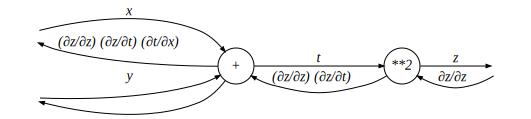

In [1]:
from graphviz import Source
net = Source(
'''digraph "G" {
    rankdir=LR
    //splines=line
    node [fontname="Times-Italic",shape=circle,fixedsize=true]
        in1 [label="", color=none];
        in2 [label="", color=none];
        plus [label="+"];
        square [label="**2"];
        out [label="", color=none];
        {rank=same; in1 in2}
        
    edge [fontname="Times-Italic",arrowsize=0.5];
        in1 -> plus [label=x];
        in2 -> plus [label=y];
        plus -> square [label=t];
        square -> out [label=z];
    
        plus -> in1 [label=<(&part;z/&part;z) (&part;z/&part;t) (&part;t/&part;x)>];
        plus -> in2 [label=""];
        square -> plus [label=<(&part;z/&part;z) (&part;z/&part;t)>];
        out -> square [label=<&part;z/&part;z>];
    
}'''
)
net

あらかじめ各所での順方向の微分値を記憶しておき、それらを掛け合わせることで連鎖率により入力に対する出力の変化値を算出できることを利用
上図の場合xの値に対するzの変化値（dz/dx）を求めたいとき、各所での結果dz/dz, dz/dt dt/dxをかけて簡単に算出できる.

### 5.3.1 加算ノードの逆伝播

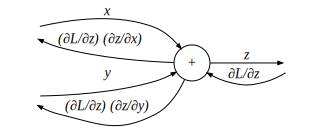

In [2]:
addG = Source(
'''digraph "G" {
    rankdir=LR
    //splines=line
    node [fontname="Times-Italic",shape=circle,fixedsize=true]
        in1 [label="", color=none];
        in2 [label="", color=none];
        plus [label="+"];
        out [label="", color=none];
        {rank=same; in1 in2}
        
    edge [fontname="Times-Italic",arrowsize=0.5];
        in1 -> plus [label=x];
        in2 -> plus [label=y];
        plus -> out [label=z];
    
        plus -> in1 [label=<(&part;L/&part;z) (&part;z/&part;x)>];
        plus -> in2 [label="(&part;L/&part;z) (&part;z/&part;y)"];
        out -> plus [label=<&part;L/&part;z>];
    
}'''
)
addG

$$
x + y = z 
$$
のとき
$$
\begin{cases}
  \frac{\partial z}{\partial x} = 1 \\
  \frac{\partial z}{\partial y} = 1 \\
\end{cases}
$$

なので**そのまま**受け渡せばいい

### 5.3.2 乗算ノードの逆伝播

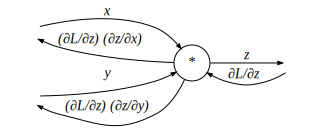

In [3]:
addG = Source(
'''digraph "G" {
    rankdir=LR
    //splines=line
    node [fontname="Times-Italic",shape=circle,fixedsize=true]
        in1 [label="", color=none];
        in2 [label="", color=none];
        plus [label="*"];
        out [label="", color=none];
        {rank=same; in1 in2}
        
    edge [fontname="Times-Italic",arrowsize=0.5];
        in1 -> plus [label=x];
        in2 -> plus [label=y];
        plus -> out [label=z];
    
        plus -> in1 [label=<(&part;L/&part;z) (&part;z/&part;x)>];
        plus -> in2 [label="(&part;L/&part;z) (&part;z/&part;y)"];
        out -> plus [label=<&part;L/&part;z>];
    
}'''
)
addG

$$
x * y = z 
$$
のとき
$$
\begin{cases}
  \frac{\partial z}{\partial x} = y \\
  \frac{\partial z}{\partial y} = x \\
\end{cases}
$$

なので**値をひっくり返して**上位へ伝えればいい

### 5.4.1 乗算レイヤの実装

In [4]:
class MulLayer(object):
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        return x * y
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy

In [5]:
apple = 100
apple_num = 2
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

220.00000000000003


In [6]:
# backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)
print(dapple)

2.2


### 5.4.2 加算ノード

In [7]:
class AddLayer(object):
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        return x + y
    
    def backward(self, dout):
        dx = dout
        dy = dout
        return dx, dy

具体的な計算は略

### 5.5.1 ReLUレイヤ

$$
y = \begin{cases}
x & (x > 0)\\
0 & (x \le 0)
\end{cases}
$$
より
$$
\frac{\partial y}{\partial x} = \begin{cases}
1 & (x > 0)\\
0 & (x \le 0)
\end{cases}
$$

x>0の時は下流の信号をそのまま伝える、<0のときはそこで信号ストップ

In [8]:
class ReLU(object):
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backword(self, dout):
        dout[self.mask] = 0
        dx = dout # ここが.copy()でない理由あるのかな
        return dx

### 5.5.2 Sigmoidレイヤ

$$
y = \frac{1} {1 + exp(-x)}
$$

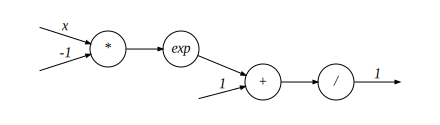

In [9]:
sigG = Source(
'''digraph "G" {
    rankdir=LR
    //splines=line
    node [fontname="Times-Italic",shape=circle,fixedsize=true]
        in1 [label="", color=none];
        in2 [label="", color=none];
        mul [label="*"];
        exp [label="exp"];
        in3 [label="", color=none];
        plus [label="+"];
        div [label="/"];
        out [label="", color=none];
        {rank=same; in1 in2}
        {rank=same; in3 exp}
        
    edge [fontname="Times-Italic",arrowsize=0.5];
        in1 -> mul [label=x];
        in2 -> mul [label=-1];
        mul -> exp [label=""];
        exp -> plus [label=""];
        in3 -> plus [label="1"];
        plus -> div [label=""];
        div-> out [label="1"];
        
}'''
)
sigG

[/レイヤ]
$$
y = 1/x
$$
より
$$
\frac{\partial y}{\partial x} = 
-\frac{1}{x^2} = - {y^2}
$$

[+レイヤ]
そのまま上位へ伝播

[expレイヤ]
$$
y = \exp(x)
$$
より
$$
\frac{\partial y}{\partial x} = 
\exp(x)
$$
今回はexp(-x)を返す(若干引っかかる)

[*レイヤ]
ひっくり返すので
$$
\frac{\partial y}{\partial x} = 
-1
$$

よって
$$
\frac{\partial L}{\partial x} = 
\frac{\partial L}{\partial y} *
-{y^2} * 
\exp(-x) *
-1 =
\frac{\partial L}{\partial y} 
{y^2}
\exp(-x)  
$$

$$
\frac{\partial L}{\partial y} 
{y^2}
\exp(-x) = 
\frac{\partial L}{\partial y} 
\frac{1}{(1 + \exp(-x))^2}
\exp(-x)=
\frac{\partial L}{\partial y} 
\frac{1}{1 + \exp(-x)}
\frac{\exp(-x)}{1 + \exp(-x)} =
\frac{\partial L}{\partial y} (1-y)y
$$

順方向からの伝播だけて表示できる

In [10]:
class Sigmoid(object):
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1/(1+np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1-self.out)*self.out
        return dx

### 5.6.1 Affineレイヤ

誤差逆伝播で行う行列の内積は、幾何学の分野ではAffine変換と呼ばれる

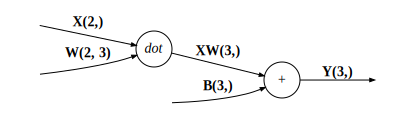

In [11]:
sigG = Source(
'''digraph "G" {
    rankdir=LR
    //splines=line
    node [fontname="Times-Italic",shape=circle,fixedsize=true]
        in1 [label="", color=none];
        in2 [label="", color=none];
        in3 [label="", color=none];
        dot [label="dot"];
        plus [label="+"];
        out [label="", color=none];
        {rank=same; in1 in2}
        {rank=same; in3 dot}
        
    edge [fontname="Times-Italic",arrowsize=0.5];
        in1 -> dot [label="X(2,)",fontname="Times-Bold"];
        in2 -> dot [label="W(2, 3)",fontname="Times-Bold"];
        dot -> plus [label="XW(3,)",fontname="Times-Bold"];
        in3 -> plus [label="B(3,)",fontname="Times-Bold"];
        plus -> out [label="Y(3,)",fontname="Times-Bold"];
        
}'''
)
sigG

逆伝播は下のような式になる

$$
\frac{\partial L}{\partial \bf{X}} = \frac{\partial L}{\partial \bf{Y}} {\bf{W}}^T \\
\frac{\partial L}{\partial \bf{W}} = {\bf{X}}^T \frac{\partial L}{\partial \bf{Y}} \\
$$

導出略とのこと（確かに要素書き出すの面倒、後で時間あればで）（XW + B = YをX,Wそれぞれで偏微分して変形すればいけそう）

### 5.6.2 バッチ版Affineレイヤ

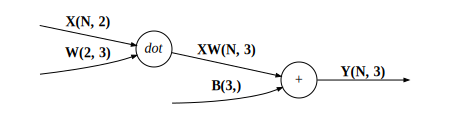

In [12]:
sigG = Source(
'''digraph "G" {
    rankdir=LR
    //splines=line
    node [fontname="Times-Italic",shape=circle,fixedsize=true]
        in1 [label="", color=none];
        in2 [label="", color=none];
        in3 [label="", color=none];
        dot [label="dot"];
        plus [label="+"];
        out [label="", color=none];
        {rank=same; in1 in2}
        {rank=same; in3 dot}
        
    edge [fontname="Times-Italic",arrowsize=0.5];
        in1 -> dot [label="X(N, 2)",fontname="Times-Bold"];
        in2 -> dot [label="W(2, 3)",fontname="Times-Bold"];
        dot -> plus [label="XW(N, 3)",fontname="Times-Bold"];
        in3 -> plus [label="B(3,)",fontname="Times-Bold"];
        plus -> out [label="Y(N, 3)",fontname="Times-Bold"];
        
}'''
)
sigG

次元が変わるだけで基本は一緒だが、バイアスについて注意が必要

In [13]:
import numpy as np
XW = np.array([[0,0,0],[10,10,10]])
B = np.array([1,2,3])
print(XW)
print(XW+B)

[[ 0  0  0]
 [10 10 10]]
[[ 1  2  3]
 [11 12 13]]


順伝播で各データに対しバイアスが加算されるため、それらを集約したものを逆伝播では使用する必要がある。

In [14]:
dY = np.array([[1,2,3],[4,5,6]])
dB = np.sum(dY, axis=0)
print(dY)
print(dB)

[[1 2 3]
 [4 5 6]]
[5 7 9]


In [15]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        sefl.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        
        return out
    
    def backword(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0) # バイアス集約
        
        return dx # そういやdWとdbはなんでselfで処理するのか？

### 5.6.3 Softmax-with-Loss レイヤ

損失関数（交差エントロピー）含めて一つにしてしまう

逆伝播の結果に注目、Softmaxからの逆伝播がy-tと綺麗な形に（というよりそうなるように設定されたのが交差エントロピー）

In [16]:
class SoftMaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t)/batch_size
        
        return dx

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        # self.layersにAffine1->Relu->Affine2の順序で格納されてるので、順繰りに計算してxで渡していく順方向伝播b
        
        return x
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads


参考:PythonのOrderedDict

In [24]:
# 通常の辞書型
a = {'one':1,'two':2,'three':3,'four':4,'five':5}
print(a)
a['six'] = 6
print(a)

{'five': 5, 'four': 4, 'three': 3, 'one': 1, 'two': 2}
{'five': 5, 'four': 4, 'two': 2, 'six': 6, 'three': 3, 'one': 1}


挿入順番が制御されない

In [25]:
from collections import OrderedDict
b = OrderedDict({'one':1,'two':2,'three':3,'four':4,'five':5})
print(b)
b['six'] = 6
print(b)

OrderedDict([('five', 5), ('four', 4), ('three', 3), ('one', 1), ('two', 2)])
OrderedDict([('five', 5), ('four', 4), ('three', 3), ('one', 1), ('two', 2), ('six', 6)])


末尾に追加、順序制御もされる（ただし初期化時は保持してくれない